# Task1: Data format changing

## import and initializing of S3

In [2]:
import boto3
import pandas as pd
import re
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime # for timestamp to day
import pytz # for timestamp to day

In [3]:
s3 = boto3.client('s3')
bucket_name = 'young-elevator-data'

## Get data from S3 raw-data and restore to format-changed-data

In [4]:
def parse_value(data):
    match = re.search(r'value=([\d\.-]+)', data)
    return float(match.group(1)) if match else None

def parse_timestamp(data):
    match = re.search(r'timestamp=(\d+)', data)
    return int(match.group(1)) if match else None

def parse_gpid(data):
    match = re.search(r'gpid=(\w+)', data)
    return match.group(1) if match else None

def parse_geid(data):
    match = re.search(r'geid=(\w+)', data)
    return match.group(1) if match else None

def convert_to_eastern(timestamp_ms):
    timestamp_sec = timestamp_ms / 1000.0
    dt_utc = datetime.utcfromtimestamp(timestamp_sec)
    dt_eastern = dt_utc.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/New_York'))
    return dt_eastern

In [5]:
def process_file(file_key, file_type):
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    lines = response['Body'].read().decode('utf-8').splitlines()

    if not lines:
        print(f"Skipping empty file: {file_key}")
        return
        
    df = pd.read_csv(io.StringIO("\n".join(lines)))
    
    df['timestamp'] = df['var_1'].apply(parse_timestamp)
    df['val_1'] = df['var_1'].apply(parse_value)
    df['accel_x_axis_g'] = df['accel_x_axis_g'].apply(parse_value)
    df['accel_y_axis_g'] = df['accel_y_axis_g'].apply(parse_value)
    df['accel_z_axis_g'] = df['accel_z_axis_g'].apply(parse_value)
    df['door_state'] = df['door_state'].apply(parse_value)
    df['PID'] = df['id'].apply(parse_gpid)
    df['EID'] = df['id'].apply(parse_geid)

    df['day'] = df['timestamp'].apply(lambda x: convert_to_eastern(x).date()) # get day
    
    df = df[['timestamp', 'val_1', 'accel_x_axis_g', 'accel_y_axis_g', 'accel_z_axis_g', 'door_state', 'PID', 'EID', 'day']]
    
    new_file_name = f"format-changed-data/{file_type}.csv"
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    s3.put_object(Bucket=bucket_name, Body=csv_buffer.getvalue(), Key=new_file_name)
    print(f"Processed and saved: {new_file_name}")

# Process train.csv and test.csv files

In [6]:
process_file("raw-data/train.csv", "train")
process_file("raw-data/test.csv", "test")

Processed and saved: format-changed-data/train.csv
Processed and saved: format-changed-data/test.csv


## read the train csv file 

In [7]:
s3_path_train = f"s3://{bucket_name}/format-changed-data/train.csv"
train_df = pd.read_csv(s3_path_train)

# TASK #2: VISUALIZE DATASET

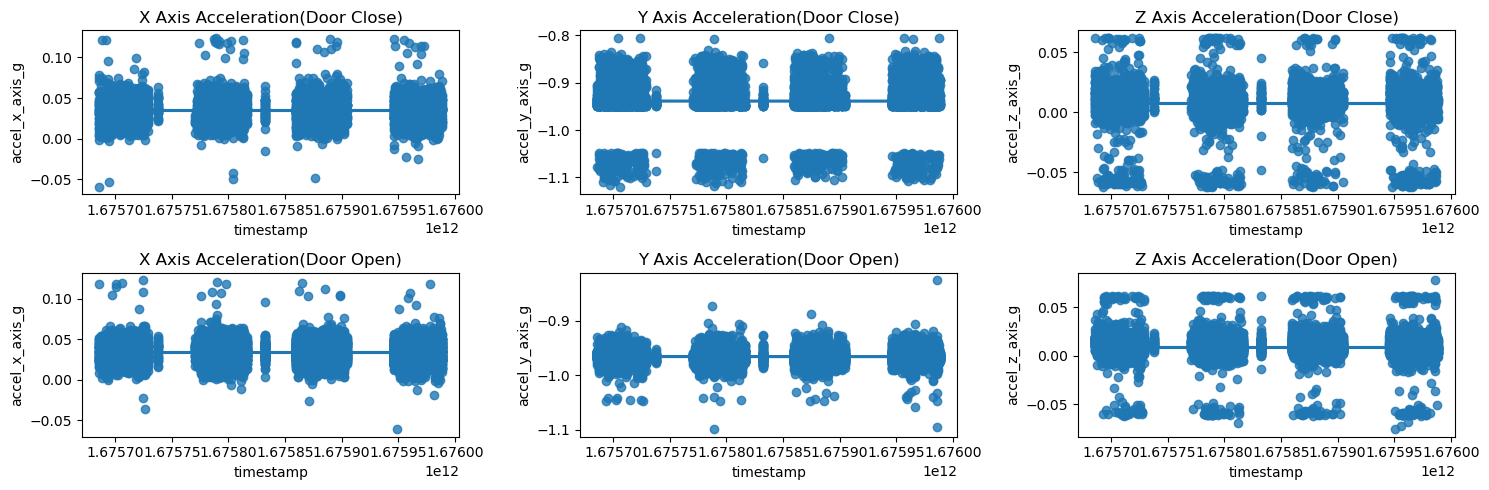

In [8]:
## Partial Data(first 2hr)
#start_time = elevator_df['timestamp'].min()
#hour_data = elevator_df[(elevator_df['timestamp'] >= start_time) & (elevator_df['timestamp'] < start_time + 92*60*60*1000) & (elevator_df['door_state'] == 1)] # Close
data_door_close = train_df[train_df['door_state'] == 1]
data_door_open = train_df[train_df['door_state'] == 0]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

#sns.regplot(x='timestamp', y='accel_x_axis_g', data=hour_data, ax=axs[0])
sns.regplot(x='timestamp', y='accel_x_axis_g', data=data_door_close, ax=axs[0,0])
axs[0,0].set_title('X Axis Acceleration(Door Close)')
#sns.regplot(x='timestamp', y='accel_y_axis_g', data=hour_data, ax=axs[1])
sns.regplot(x='timestamp', y='accel_y_axis_g', data=data_door_close, ax=axs[0,1])
axs[0,1].set_title('Y Axis Acceleration(Door Close)')
#sns.regplot(x='timestamp', y='accel_z_axis_g', data=hour_data, ax=axs[2])
sns.regplot(x='timestamp', y='accel_z_axis_g', data=data_door_close, ax=axs[0,2])
axs[0,2].set_title('Z Axis Acceleration(Door Close)')

sns.regplot(x='timestamp', y='accel_x_axis_g', data=data_door_open, ax=axs[1,0])
axs[1,0].set_title('X Axis Acceleration(Door Open)')
sns.regplot(x='timestamp', y='accel_y_axis_g', data=data_door_open, ax=axs[1,1])
axs[1,1].set_title('Y Axis Acceleration(Door Open)')
sns.regplot(x='timestamp', y='accel_z_axis_g', data=data_door_open, ax=axs[1,2])
axs[1,2].set_title('Z Axis Acceleration(Door Open)')
            
            
plt.tight_layout()
plt.show()

# draw to show there is no trend 

# TASK 3: RCF(Random Cut Forest) - x/y/z acceleration according to door status

In [9]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker import RandomCutForest

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket_name = 'young-elevator-data'
prefix = 'format-changed-data/'
train_file_name = 'train.csv'
test_file_name = 'test.csv'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Train the model using 'train.csv'

In [10]:
train_data_location = f's3://{bucket_name}/{prefix}{train_file_name}'
train_data = pd.read_csv(train_data_location)
filtered_train_data = train_data[train_data['door_state'] == 1]
X_train = filtered_train_data[['accel_x_axis_g', 'accel_y_axis_g', 'accel_z_axis_g']].values

rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location=f's3://{bucket_name}/metadata/',
                      output_path=f's3://{bucket_name}/output',
                      num_samples_per_tree=512,
                      num_trees=50)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [11]:
rcf.fit(rcf.record_set(X_train))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2023-11-14-20-33-11-467


2023-11-14 20:33:11 Starting - Starting the training job...
2023-11-14 20:33:39 Starting - Preparing the instances for training.........
2023-11-14 20:34:51 Downloading - Downloading input data...
2023-11-14 20:35:26 Training - Downloading the training image......
2023-11-14 20:36:37 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/14/2023 20:36:58 INFO 140452855502656] Reading default configuration f

In [12]:
rcf_predictor = rcf.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2023-11-14-20-39-47-275
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2023-11-14-20-39-47-275
INFO:sagemaker:Creating endpoint with name randomcutforest-2023-11-14-20-39-47-275


-----------------!

In [13]:
results = rcf_predictor.predict(X_train)

In [14]:
train_rcf_scores = [datum.label['score'].float32_tensor.values[0] for datum in results]
print(rcf_predictor)

RandomCutForestPredictor: {'endpoint_name': 'randomcutforest-2023-11-14-20-39-47-275', 'sagemaker_session': <sagemaker.session.Session object at 0x7f85c14be0b0>, 'serializer': <sagemaker.amazon.common.RecordSerializer object at 0x7f85c1f96140>, 'deserializer': <sagemaker.amazon.common.RecordDeserializer object at 0x7f85c1f961a0>}


### Training Model Average RCF Score in Closing Door

In [15]:
# Create a new column initialized with NaN values
train_df['RCF Score'] = np.nan

# Update only the rows that match the filtered_data2 index
train_df.loc[filtered_train_data.index, 'RCF Score'] = train_rcf_scores

# Group by day and calculate the mean RCF Score
train_daily_rcf_scores = train_df.groupby('day')['RCF Score'].mean().reset_index()

print(train_daily_rcf_scores)

          day  RCF Score
0  2023-02-06   0.689082
1  2023-02-07   0.710682
2  2023-02-08   0.692681
3  2023-02-09   0.711257


## Training Data Visualization in Closing Door

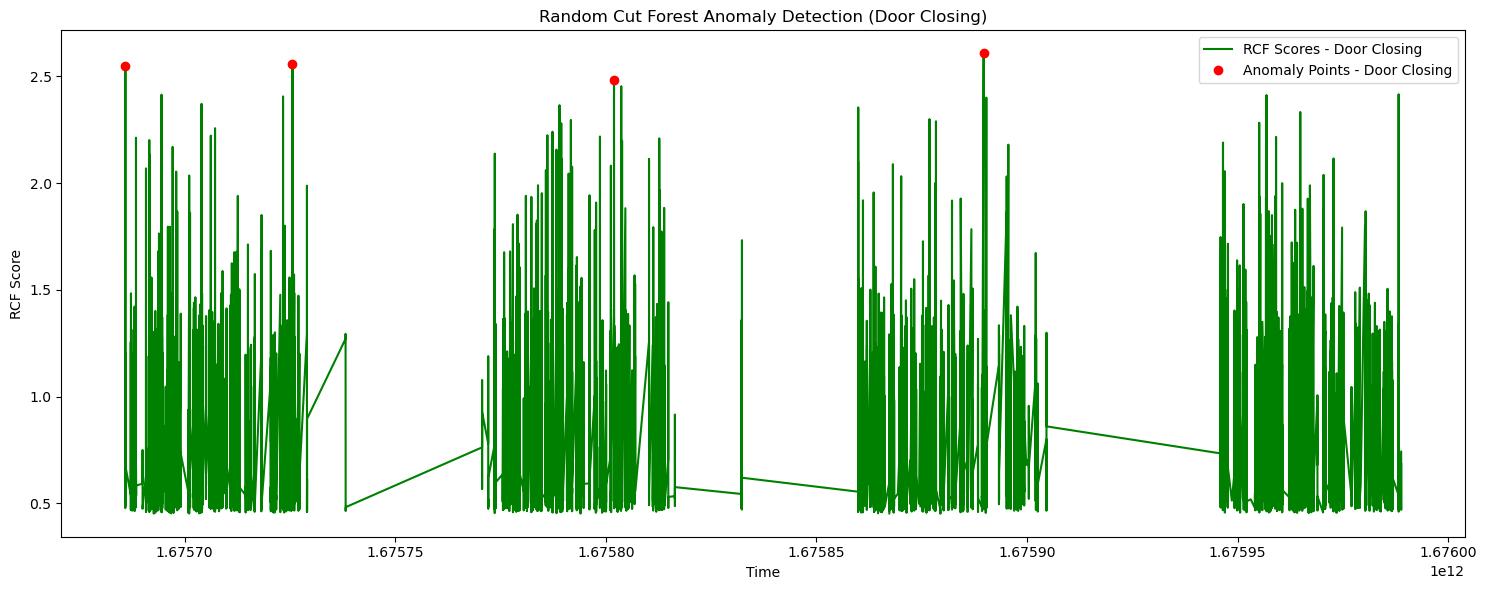

In [31]:
# Assuming 'timestamps' column in your data
timestamps = filtered_train_data['timestamp'].values

# Determine a threshold for anomaly detection (this is arbitrary and can be adjusted)
threshold = max(train_rcf_scores) * 0.95

anomaly_points = [score if score > threshold else None for score in train_rcf_scores]

# Plotting in separate subplots
fig, ax = plt.subplots(figsize=(15, 6))

# Door Closing State
ax.plot(timestamps, train_rcf_scores, label='RCF Scores - Door Closing', color='green')
ax.plot(timestamps, anomaly_points, 'ro', label='Anomaly Points - Door Closing')
ax.set_title('Random Cut Forest Anomaly Detection (Door Closing)')
ax.set_xlabel('Time')
ax.set_ylabel('RCF Score')
ax.legend()
#axes[0].set_xlim([1675685889003, 1675687218382]) // for viewing partialy

plt.tight_layout()
plt.show()

In [17]:
# For the "door closing" state
print("\nAnomaly Timestamps for Door Closing State:")
for timestamp, score in zip(timestamps, train_rcf_scores):
    if score > threshold:
        print(timestamp)


Anomaly Timestamps for Door Closing State:
1675889681706


# Task 4: Testing the Model with Test Data

In [18]:
test_data_location = f's3://{bucket_name}/{prefix}{test_file_name}'
test_data = pd.read_csv(test_data_location)
filtered_test_data = test_data[test_data['door_state'] == 1]
X_test = filtered_test_data[['accel_x_axis_g', 'accel_y_axis_g', 'accel_z_axis_g']].values

## Predict anomalies on the test data

In [19]:
results = rcf_predictor.predict(X_test)

In [20]:
test_rcf_scores = [datum.label['score'].float32_tensor.values[0] for datum in results]
print(rcf_predictor)

RandomCutForestPredictor: {'endpoint_name': 'randomcutforest-2023-11-14-20-39-47-275', 'sagemaker_session': <sagemaker.session.Session object at 0x7f85c14be0b0>, 'serializer': <sagemaker.amazon.common.RecordSerializer object at 0x7f85c1f96140>, 'deserializer': <sagemaker.amazon.common.RecordDeserializer object at 0x7f85c1f961a0>}


### Testing Model Average RCF Score in Closing Door

In [21]:
s3_path_test = f"s3://{bucket_name}/format-changed-data/test.csv"
test_df = pd.read_csv(s3_path_test)

# Create a new column initialized with NaN values
test_df['RCF Score'] = np.nan

# Update only the rows that match the filtered_data2 index
test_df.loc[filtered_test_data.index, 'RCF Score'] = test_rcf_scores

# Group by day and calculate the mean RCF Score
test_daily_rcf_scores = test_df.groupby('day')['RCF Score'].mean().reset_index()

print(test_daily_rcf_scores)

          day  RCF Score
0  2023-02-10   0.686799
1  2023-02-11   0.688704
2  2023-02-12   0.697294


## Testing Data Visualization in Closing Door

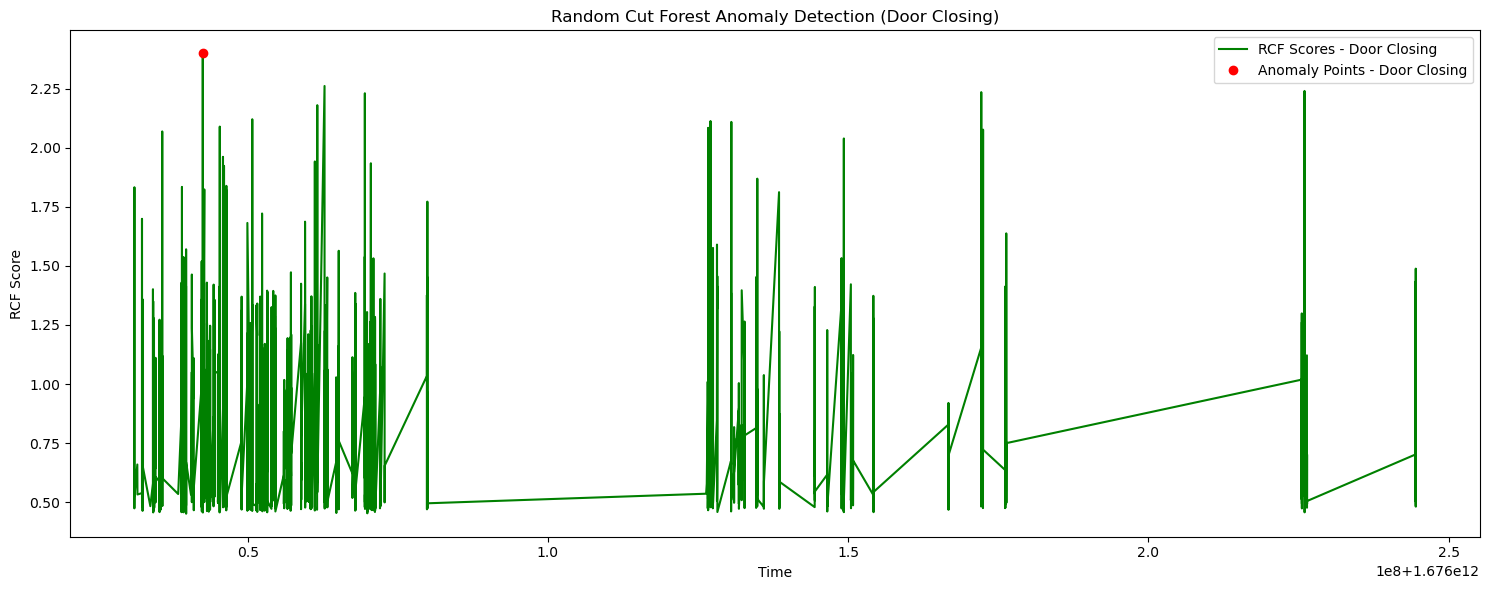

In [22]:
# Assuming 'timestamps' column in your data
timestamps = filtered_test_data['timestamp'].values

# Determine a threshold for anomaly detection (this is arbitrary and can be adjusted)
threshold = max(test_rcf_scores) * 0.99

anomaly_points = [score if score > threshold else None for score in test_rcf_scores]

# Plotting in separate subplots
fig, ax = plt.subplots(figsize=(15, 6))

# Door Closing State
ax.plot(timestamps, test_rcf_scores, label='RCF Scores - Door Closing', color='green')
ax.plot(timestamps, anomaly_points, 'ro', label='Anomaly Points - Door Closing')
ax.set_title('Random Cut Forest Anomaly Detection (Door Closing)')
ax.set_xlabel('Time')
ax.set_ylabel('RCF Score')
ax.legend()

plt.tight_layout()
plt.show()

In [23]:
# For the "door closing" state
print("\nAnomaly Timestamps for Door Closing State:")
for timestamp, score in zip(timestamps, test_rcf_scores):
    if score > threshold:
        print(timestamp)


Anomaly Timestamps for Door Closing State:
1676042512931


# Task 5: Release Resource

In [24]:
rcf_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: randomcutforest-2023-11-14-20-39-47-275
INFO:sagemaker:Deleting endpoint with name: randomcutforest-2023-11-14-20-39-47-275


# Task 6: Compare Training and Testing Data

## Compare Training and Testing Data

In [25]:
def plot_distribution(train_scores, test_scores, train_label, test_label):
    plt.figure(figsize=(10, 5))
    sns.histplot(train_scores, color="blue", kde=True, label=train_label)
    sns.histplot(test_scores, color="red", kde=True, label=test_label)
    plt.xlabel('RCF Score')
    plt.title('Distribution of RCF Scores Between Training and Testing Data')
    plt.legend()
    plt.show()

## Plot the distribution of RCF scores for train and test data

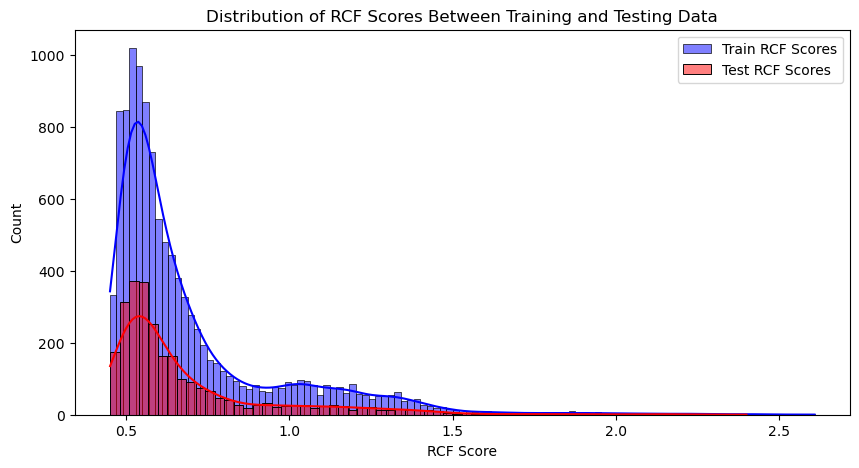

In [26]:
plot_distribution(
    train_df['RCF Score'].dropna(),
    test_df['RCF Score'].dropna(),
    'Train RCF Scores',
    'Test RCF Scores'
)

## Compare daily rcf scores

In [27]:
print(train_daily_rcf_scores)

          day  RCF Score
0  2023-02-06   0.689082
1  2023-02-07   0.710682
2  2023-02-08   0.692681
3  2023-02-09   0.711257


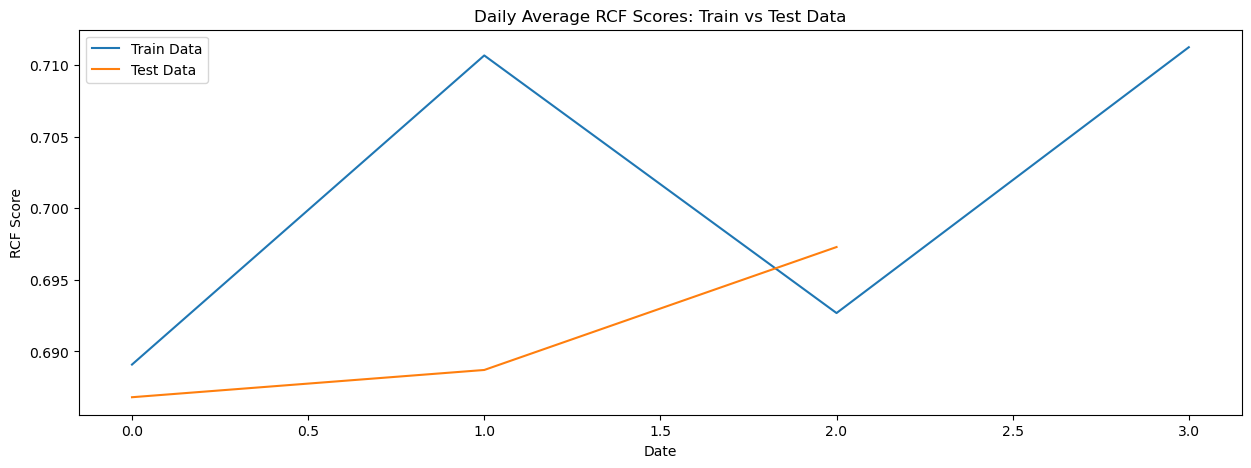

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(train_daily_rcf_scores.index, train_daily_rcf_scores['RCF Score'].values, label='Train Data')
plt.plot(test_daily_rcf_scores.index, test_daily_rcf_scores['RCF Score'].values, label='Test Data')
plt.legend()
plt.title('Daily Average RCF Scores: Train vs Test Data')
plt.xlabel('Date')
plt.ylabel('RCF Score')
plt.show()